## Import libraries and MNIST dataset

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



## Define Convolutional Autoencoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
        
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## Initialize Loss function and the optimizer

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Train and evaluate model

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   


## Let's train!

	 partial train loss (single batch): 0.253613
	 partial train loss (single batch): 0.246608
	 partial train loss (single batch): 0.240863
	 partial train loss (single batch): 0.235822
	 partial train loss (single batch): 0.232069
	 partial train loss (single batch): 0.228418
	 partial train loss (single batch): 0.225299
	 partial train loss (single batch): 0.222743
	 partial train loss (single batch): 0.219850
	 partial train loss (single batch): 0.217574
	 partial train loss (single batch): 0.215299
	 partial train loss (single batch): 0.212904
	 partial train loss (single batch): 0.211315
	 partial train loss (single batch): 0.208991
	 partial train loss (single batch): 0.206697
	 partial train loss (single batch): 0.205085
	 partial train loss (single batch): 0.203015
	 partial train loss (single batch): 0.200926
	 partial train loss (single batch): 0.199485
	 partial train loss (single batch): 0.197232
	 partial train loss (single batch): 0.195117
	 partial train loss (single batch

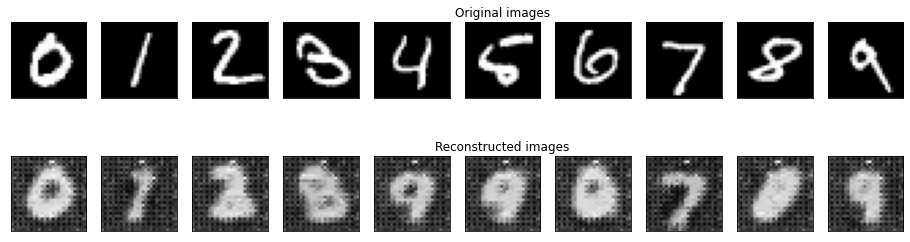

	 partial train loss (single batch): 0.065966
	 partial train loss (single batch): 0.066390
	 partial train loss (single batch): 0.066382
	 partial train loss (single batch): 0.066591
	 partial train loss (single batch): 0.065742
	 partial train loss (single batch): 0.065821
	 partial train loss (single batch): 0.065091
	 partial train loss (single batch): 0.064226
	 partial train loss (single batch): 0.064148
	 partial train loss (single batch): 0.065237
	 partial train loss (single batch): 0.064894
	 partial train loss (single batch): 0.064322
	 partial train loss (single batch): 0.063363
	 partial train loss (single batch): 0.063720
	 partial train loss (single batch): 0.063567
	 partial train loss (single batch): 0.063321
	 partial train loss (single batch): 0.062781
	 partial train loss (single batch): 0.062765
	 partial train loss (single batch): 0.062516
	 partial train loss (single batch): 0.062922
	 partial train loss (single batch): 0.063057
	 partial train loss (single batch

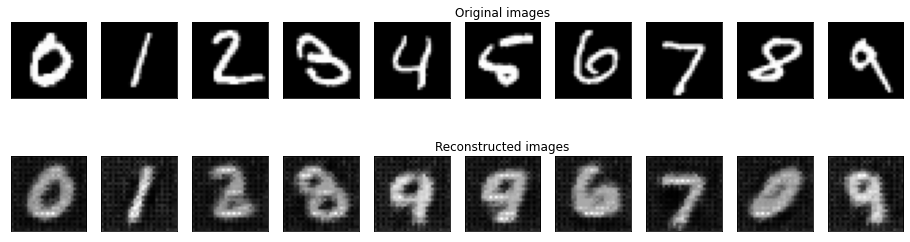

	 partial train loss (single batch): 0.045915
	 partial train loss (single batch): 0.046860
	 partial train loss (single batch): 0.046699
	 partial train loss (single batch): 0.047570
	 partial train loss (single batch): 0.046528
	 partial train loss (single batch): 0.047154
	 partial train loss (single batch): 0.046045
	 partial train loss (single batch): 0.045228
	 partial train loss (single batch): 0.045515
	 partial train loss (single batch): 0.046962
	 partial train loss (single batch): 0.046864
	 partial train loss (single batch): 0.046269
	 partial train loss (single batch): 0.046137
	 partial train loss (single batch): 0.045299
	 partial train loss (single batch): 0.045812
	 partial train loss (single batch): 0.045256
	 partial train loss (single batch): 0.045372
	 partial train loss (single batch): 0.044851
	 partial train loss (single batch): 0.044997
	 partial train loss (single batch): 0.045453
	 partial train loss (single batch): 0.046724
	 partial train loss (single batch

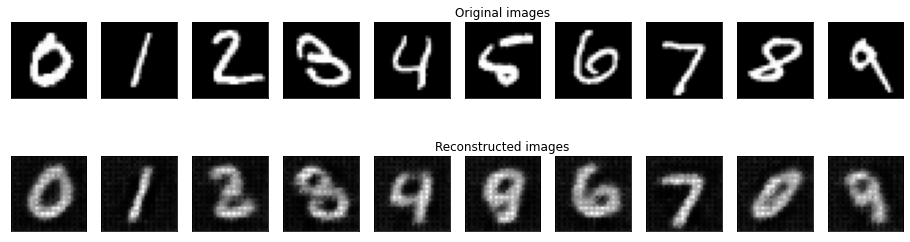

	 partial train loss (single batch): 0.037186
	 partial train loss (single batch): 0.038482
	 partial train loss (single batch): 0.038290
	 partial train loss (single batch): 0.039467
	 partial train loss (single batch): 0.038013
	 partial train loss (single batch): 0.038373
	 partial train loss (single batch): 0.037817
	 partial train loss (single batch): 0.036729
	 partial train loss (single batch): 0.037445
	 partial train loss (single batch): 0.038735
	 partial train loss (single batch): 0.038834
	 partial train loss (single batch): 0.037872
	 partial train loss (single batch): 0.038568
	 partial train loss (single batch): 0.036688
	 partial train loss (single batch): 0.037509
	 partial train loss (single batch): 0.036807
	 partial train loss (single batch): 0.037576
	 partial train loss (single batch): 0.036531
	 partial train loss (single batch): 0.036927
	 partial train loss (single batch): 0.036985
	 partial train loss (single batch): 0.039228
	 partial train loss (single batch

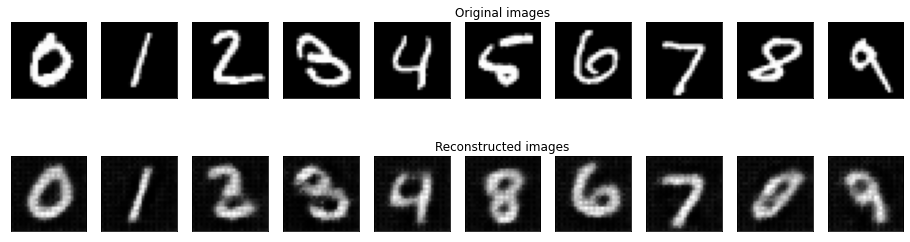

	 partial train loss (single batch): 0.032865
	 partial train loss (single batch): 0.034377
	 partial train loss (single batch): 0.034227
	 partial train loss (single batch): 0.035490
	 partial train loss (single batch): 0.033746
	 partial train loss (single batch): 0.034246
	 partial train loss (single batch): 0.033363
	 partial train loss (single batch): 0.032813
	 partial train loss (single batch): 0.033461
	 partial train loss (single batch): 0.034752
	 partial train loss (single batch): 0.034705
	 partial train loss (single batch): 0.033910
	 partial train loss (single batch): 0.035063
	 partial train loss (single batch): 0.032376
	 partial train loss (single batch): 0.033511
	 partial train loss (single batch): 0.032852
	 partial train loss (single batch): 0.033698
	 partial train loss (single batch): 0.032726
	 partial train loss (single batch): 0.033128
	 partial train loss (single batch): 0.032868
	 partial train loss (single batch): 0.035639
	 partial train loss (single batch

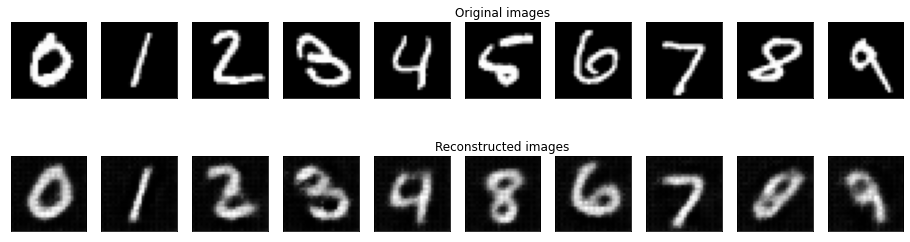

	 partial train loss (single batch): 0.030699
	 partial train loss (single batch): 0.032398
	 partial train loss (single batch): 0.032191
	 partial train loss (single batch): 0.033490
	 partial train loss (single batch): 0.031808
	 partial train loss (single batch): 0.032313
	 partial train loss (single batch): 0.031343
	 partial train loss (single batch): 0.031049
	 partial train loss (single batch): 0.031631
	 partial train loss (single batch): 0.032826
	 partial train loss (single batch): 0.032758
	 partial train loss (single batch): 0.032129
	 partial train loss (single batch): 0.033266
	 partial train loss (single batch): 0.030484
	 partial train loss (single batch): 0.031840
	 partial train loss (single batch): 0.031021
	 partial train loss (single batch): 0.031900
	 partial train loss (single batch): 0.030884
	 partial train loss (single batch): 0.031349
	 partial train loss (single batch): 0.031035
	 partial train loss (single batch): 0.033680
	 partial train loss (single batch

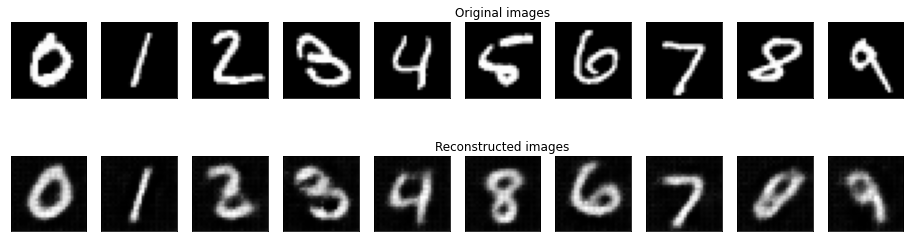

	 partial train loss (single batch): 0.029579
	 partial train loss (single batch): 0.031127
	 partial train loss (single batch): 0.030924
	 partial train loss (single batch): 0.032194
	 partial train loss (single batch): 0.030665
	 partial train loss (single batch): 0.031228
	 partial train loss (single batch): 0.030179
	 partial train loss (single batch): 0.029882
	 partial train loss (single batch): 0.030452
	 partial train loss (single batch): 0.031738
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch): 0.031028
	 partial train loss (single batch): 0.032145
	 partial train loss (single batch): 0.029226
	 partial train loss (single batch): 0.030688
	 partial train loss (single batch): 0.030056
	 partial train loss (single batch): 0.030591
	 partial train loss (single batch): 0.029719
	 partial train loss (single batch): 0.030045
	 partial train loss (single batch): 0.029836
	 partial train loss (single batch): 0.032717
	 partial train loss (single batch

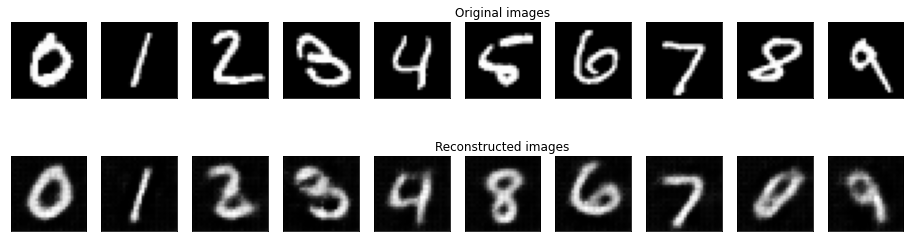

	 partial train loss (single batch): 0.028704
	 partial train loss (single batch): 0.030390
	 partial train loss (single batch): 0.030044
	 partial train loss (single batch): 0.031405
	 partial train loss (single batch): 0.029753
	 partial train loss (single batch): 0.030518
	 partial train loss (single batch): 0.029486
	 partial train loss (single batch): 0.029149
	 partial train loss (single batch): 0.029589
	 partial train loss (single batch): 0.030884
	 partial train loss (single batch): 0.030539
	 partial train loss (single batch): 0.030274
	 partial train loss (single batch): 0.031382
	 partial train loss (single batch): 0.028538
	 partial train loss (single batch): 0.029965
	 partial train loss (single batch): 0.029255
	 partial train loss (single batch): 0.029847
	 partial train loss (single batch): 0.028881
	 partial train loss (single batch): 0.029312
	 partial train loss (single batch): 0.029013
	 partial train loss (single batch): 0.032019
	 partial train loss (single batch

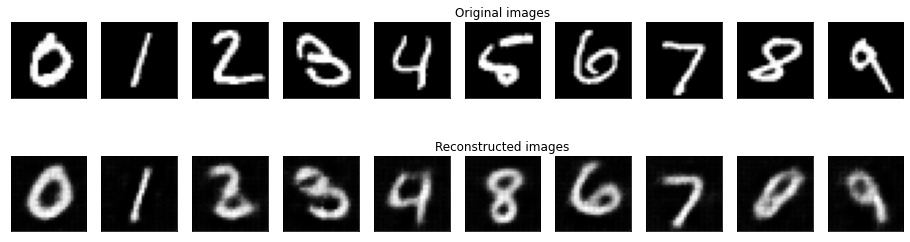

	 partial train loss (single batch): 0.028060
	 partial train loss (single batch): 0.029797
	 partial train loss (single batch): 0.029487
	 partial train loss (single batch): 0.030886
	 partial train loss (single batch): 0.028995
	 partial train loss (single batch): 0.029855
	 partial train loss (single batch): 0.028944
	 partial train loss (single batch): 0.028591
	 partial train loss (single batch): 0.029084
	 partial train loss (single batch): 0.030369
	 partial train loss (single batch): 0.029808
	 partial train loss (single batch): 0.029702
	 partial train loss (single batch): 0.030762
	 partial train loss (single batch): 0.027918
	 partial train loss (single batch): 0.029368
	 partial train loss (single batch): 0.028630
	 partial train loss (single batch): 0.029348
	 partial train loss (single batch): 0.028454
	 partial train loss (single batch): 0.028701
	 partial train loss (single batch): 0.028319
	 partial train loss (single batch): 0.031522
	 partial train loss (single batch

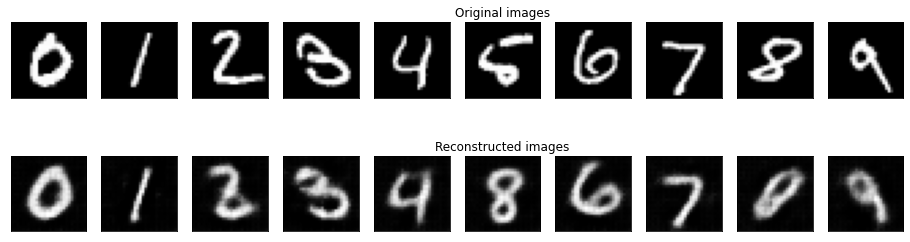

	 partial train loss (single batch): 0.027531
	 partial train loss (single batch): 0.029336
	 partial train loss (single batch): 0.029111
	 partial train loss (single batch): 0.030404
	 partial train loss (single batch): 0.028517
	 partial train loss (single batch): 0.029472
	 partial train loss (single batch): 0.028464
	 partial train loss (single batch): 0.028152
	 partial train loss (single batch): 0.028680
	 partial train loss (single batch): 0.029867
	 partial train loss (single batch): 0.029325
	 partial train loss (single batch): 0.029203
	 partial train loss (single batch): 0.030361
	 partial train loss (single batch): 0.027522
	 partial train loss (single batch): 0.028988
	 partial train loss (single batch): 0.028191
	 partial train loss (single batch): 0.028876
	 partial train loss (single batch): 0.027972
	 partial train loss (single batch): 0.028143
	 partial train loss (single batch): 0.027810
	 partial train loss (single batch): 0.031075
	 partial train loss (single batch

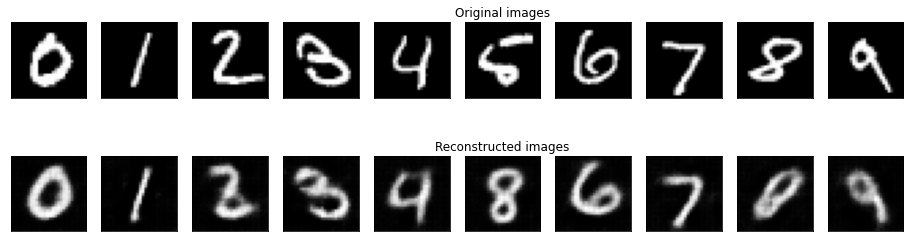

	 partial train loss (single batch): 0.027172
	 partial train loss (single batch): 0.028923
	 partial train loss (single batch): 0.028782
	 partial train loss (single batch): 0.030181
	 partial train loss (single batch): 0.028157
	 partial train loss (single batch): 0.029075
	 partial train loss (single batch): 0.028000
	 partial train loss (single batch): 0.027761
	 partial train loss (single batch): 0.028266
	 partial train loss (single batch): 0.029396
	 partial train loss (single batch): 0.028899
	 partial train loss (single batch): 0.028822
	 partial train loss (single batch): 0.029901
	 partial train loss (single batch): 0.027202
	 partial train loss (single batch): 0.028665
	 partial train loss (single batch): 0.027784
	 partial train loss (single batch): 0.028309
	 partial train loss (single batch): 0.027532
	 partial train loss (single batch): 0.027804
	 partial train loss (single batch): 0.027362
	 partial train loss (single batch): 0.030655
	 partial train loss (single batch

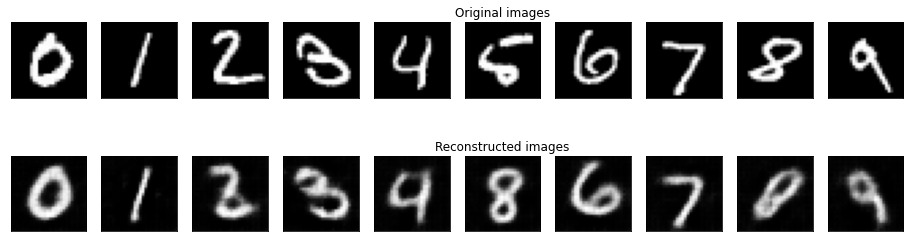

	 partial train loss (single batch): 0.026908
	 partial train loss (single batch): 0.028563
	 partial train loss (single batch): 0.028477
	 partial train loss (single batch): 0.029776
	 partial train loss (single batch): 0.027809
	 partial train loss (single batch): 0.028757
	 partial train loss (single batch): 0.027633
	 partial train loss (single batch): 0.027294
	 partial train loss (single batch): 0.027922
	 partial train loss (single batch): 0.029130
	 partial train loss (single batch): 0.028606
	 partial train loss (single batch): 0.028532
	 partial train loss (single batch): 0.029597
	 partial train loss (single batch): 0.026852
	 partial train loss (single batch): 0.028352
	 partial train loss (single batch): 0.027426
	 partial train loss (single batch): 0.027951
	 partial train loss (single batch): 0.027273
	 partial train loss (single batch): 0.027662
	 partial train loss (single batch): 0.027103
	 partial train loss (single batch): 0.030323
	 partial train loss (single batch

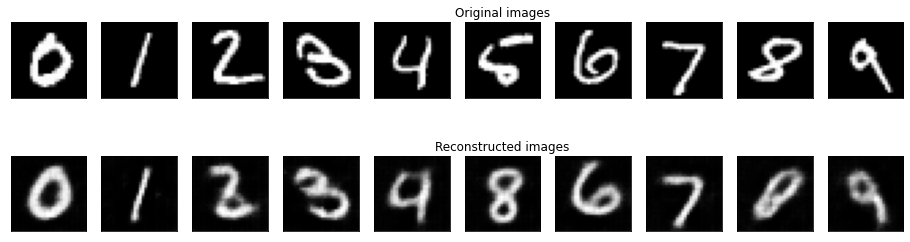

	 partial train loss (single batch): 0.026631
	 partial train loss (single batch): 0.028290
	 partial train loss (single batch): 0.028229
	 partial train loss (single batch): 0.029490
	 partial train loss (single batch): 0.027663
	 partial train loss (single batch): 0.028477
	 partial train loss (single batch): 0.027419
	 partial train loss (single batch): 0.027072
	 partial train loss (single batch): 0.027728
	 partial train loss (single batch): 0.028812
	 partial train loss (single batch): 0.028315
	 partial train loss (single batch): 0.028314
	 partial train loss (single batch): 0.029283
	 partial train loss (single batch): 0.026566
	 partial train loss (single batch): 0.028211
	 partial train loss (single batch): 0.027224
	 partial train loss (single batch): 0.027679
	 partial train loss (single batch): 0.027024
	 partial train loss (single batch): 0.027436
	 partial train loss (single batch): 0.026794
	 partial train loss (single batch): 0.029975
	 partial train loss (single batch

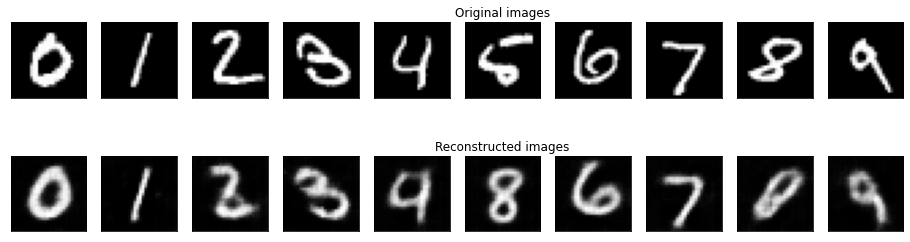

	 partial train loss (single batch): 0.026341
	 partial train loss (single batch): 0.028043
	 partial train loss (single batch): 0.027984
	 partial train loss (single batch): 0.029162
	 partial train loss (single batch): 0.027447
	 partial train loss (single batch): 0.028238
	 partial train loss (single batch): 0.027105
	 partial train loss (single batch): 0.026903
	 partial train loss (single batch): 0.027517
	 partial train loss (single batch): 0.028676
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.028193
	 partial train loss (single batch): 0.028989
	 partial train loss (single batch): 0.026383
	 partial train loss (single batch): 0.028028
	 partial train loss (single batch): 0.026942
	 partial train loss (single batch): 0.027410
	 partial train loss (single batch): 0.026883
	 partial train loss (single batch): 0.027149
	 partial train loss (single batch): 0.026525
	 partial train loss (single batch): 0.029800
	 partial train loss (single batch

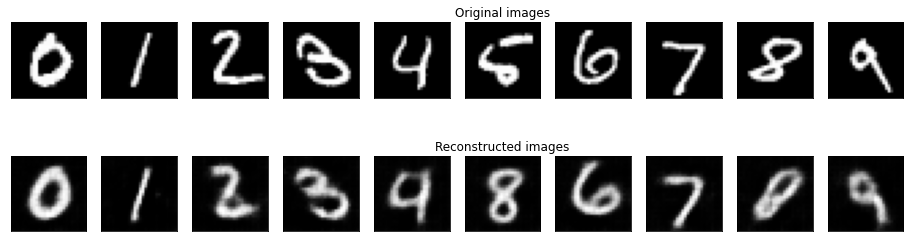

	 partial train loss (single batch): 0.026195
	 partial train loss (single batch): 0.027962
	 partial train loss (single batch): 0.027785
	 partial train loss (single batch): 0.028941
	 partial train loss (single batch): 0.027287
	 partial train loss (single batch): 0.028127
	 partial train loss (single batch): 0.026866
	 partial train loss (single batch): 0.026698
	 partial train loss (single batch): 0.027253
	 partial train loss (single batch): 0.028479
	 partial train loss (single batch): 0.027777
	 partial train loss (single batch): 0.028089
	 partial train loss (single batch): 0.028832
	 partial train loss (single batch): 0.026200
	 partial train loss (single batch): 0.027829
	 partial train loss (single batch): 0.026819
	 partial train loss (single batch): 0.027174
	 partial train loss (single batch): 0.026785
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.026302
	 partial train loss (single batch): 0.029663
	 partial train loss (single batch

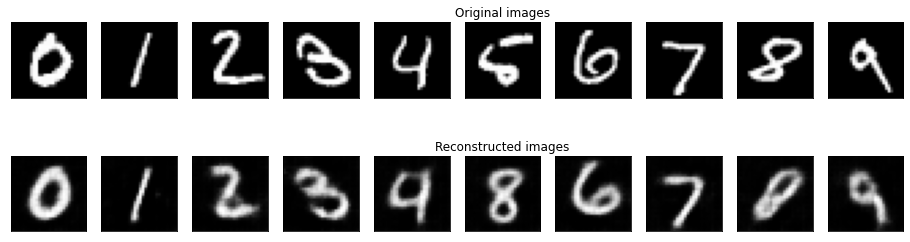

	 partial train loss (single batch): 0.026101
	 partial train loss (single batch): 0.027858
	 partial train loss (single batch): 0.027566
	 partial train loss (single batch): 0.028771
	 partial train loss (single batch): 0.027082
	 partial train loss (single batch): 0.028003
	 partial train loss (single batch): 0.026735
	 partial train loss (single batch): 0.026524
	 partial train loss (single batch): 0.027092
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.027647
	 partial train loss (single batch): 0.027981
	 partial train loss (single batch): 0.028611
	 partial train loss (single batch): 0.026196
	 partial train loss (single batch): 0.027680
	 partial train loss (single batch): 0.026683
	 partial train loss (single batch): 0.026965
	 partial train loss (single batch): 0.026690
	 partial train loss (single batch): 0.026719
	 partial train loss (single batch): 0.026178
	 partial train loss (single batch): 0.029547
	 partial train loss (single batch

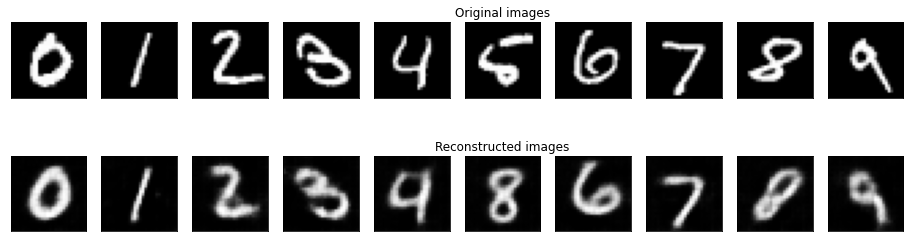

	 partial train loss (single batch): 0.025960
	 partial train loss (single batch): 0.027645
	 partial train loss (single batch): 0.027342
	 partial train loss (single batch): 0.028516
	 partial train loss (single batch): 0.026830
	 partial train loss (single batch): 0.027873
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.026355
	 partial train loss (single batch): 0.026903
	 partial train loss (single batch): 0.028022
	 partial train loss (single batch): 0.027370
	 partial train loss (single batch): 0.027808
	 partial train loss (single batch): 0.028386
	 partial train loss (single batch): 0.026067
	 partial train loss (single batch): 0.027502
	 partial train loss (single batch): 0.026559
	 partial train loss (single batch): 0.026844
	 partial train loss (single batch): 0.026686
	 partial train loss (single batch): 0.026725
	 partial train loss (single batch): 0.026081
	 partial train loss (single batch): 0.029382
	 partial train loss (single batch

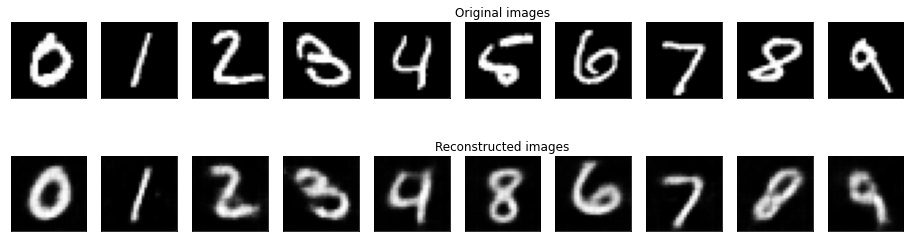

	 partial train loss (single batch): 0.025800
	 partial train loss (single batch): 0.027479
	 partial train loss (single batch): 0.027179
	 partial train loss (single batch): 0.028381
	 partial train loss (single batch): 0.026628
	 partial train loss (single batch): 0.027609
	 partial train loss (single batch): 0.026507
	 partial train loss (single batch): 0.026209
	 partial train loss (single batch): 0.026708
	 partial train loss (single batch): 0.027847
	 partial train loss (single batch): 0.027150
	 partial train loss (single batch): 0.027719
	 partial train loss (single batch): 0.028129
	 partial train loss (single batch): 0.025918
	 partial train loss (single batch): 0.027329
	 partial train loss (single batch): 0.026317
	 partial train loss (single batch): 0.026597
	 partial train loss (single batch): 0.026441
	 partial train loss (single batch): 0.026496
	 partial train loss (single batch): 0.025941
	 partial train loss (single batch): 0.029214
	 partial train loss (single batch

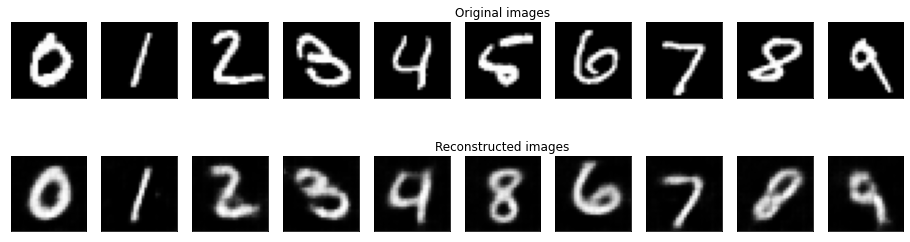

	 partial train loss (single batch): 0.025717
	 partial train loss (single batch): 0.027411
	 partial train loss (single batch): 0.027064
	 partial train loss (single batch): 0.028262
	 partial train loss (single batch): 0.026575
	 partial train loss (single batch): 0.027522
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.026151
	 partial train loss (single batch): 0.026574
	 partial train loss (single batch): 0.027727
	 partial train loss (single batch): 0.027002
	 partial train loss (single batch): 0.027668
	 partial train loss (single batch): 0.028118
	 partial train loss (single batch): 0.025776
	 partial train loss (single batch): 0.027264
	 partial train loss (single batch): 0.026203
	 partial train loss (single batch): 0.026557
	 partial train loss (single batch): 0.026309
	 partial train loss (single batch): 0.026362
	 partial train loss (single batch): 0.025778
	 partial train loss (single batch): 0.029100
	 partial train loss (single batch

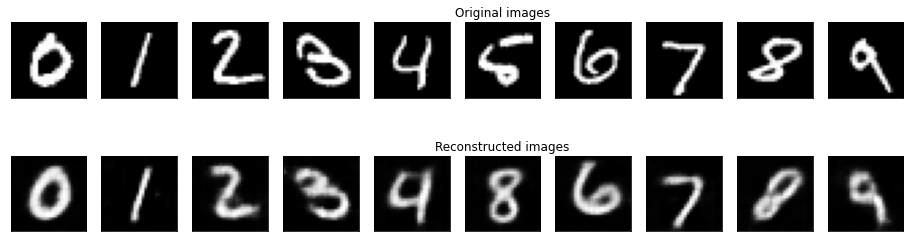

	 partial train loss (single batch): 0.025630
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch): 0.026901
	 partial train loss (single batch): 0.028147
	 partial train loss (single batch): 0.026444
	 partial train loss (single batch): 0.027406
	 partial train loss (single batch): 0.026278
	 partial train loss (single batch): 0.025938
	 partial train loss (single batch): 0.026386
	 partial train loss (single batch): 0.027570
	 partial train loss (single batch): 0.026884
	 partial train loss (single batch): 0.027551
	 partial train loss (single batch): 0.028001
	 partial train loss (single batch): 0.025703
	 partial train loss (single batch): 0.027170
	 partial train loss (single batch): 0.026199
	 partial train loss (single batch): 0.026422
	 partial train loss (single batch): 0.026219
	 partial train loss (single batch): 0.026308
	 partial train loss (single batch): 0.025714
	 partial train loss (single batch): 0.028931
	 partial train loss (single batch

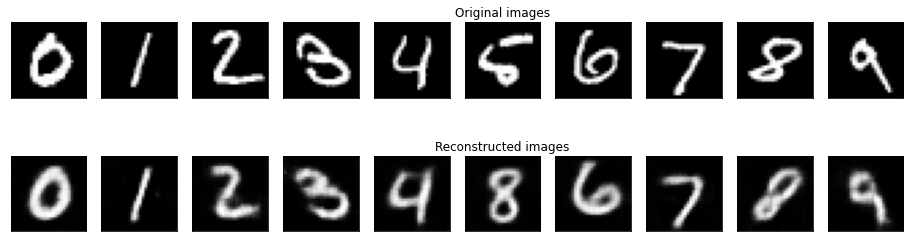

	 partial train loss (single batch): 0.025463
	 partial train loss (single batch): 0.027093
	 partial train loss (single batch): 0.026769
	 partial train loss (single batch): 0.027908
	 partial train loss (single batch): 0.026311
	 partial train loss (single batch): 0.027239
	 partial train loss (single batch): 0.026188
	 partial train loss (single batch): 0.025863
	 partial train loss (single batch): 0.026234
	 partial train loss (single batch): 0.027415
	 partial train loss (single batch): 0.026765
	 partial train loss (single batch): 0.027538
	 partial train loss (single batch): 0.027850
	 partial train loss (single batch): 0.025531
	 partial train loss (single batch): 0.026991
	 partial train loss (single batch): 0.026097
	 partial train loss (single batch): 0.026400
	 partial train loss (single batch): 0.026116
	 partial train loss (single batch): 0.026237
	 partial train loss (single batch): 0.025671
	 partial train loss (single batch): 0.028845
	 partial train loss (single batch

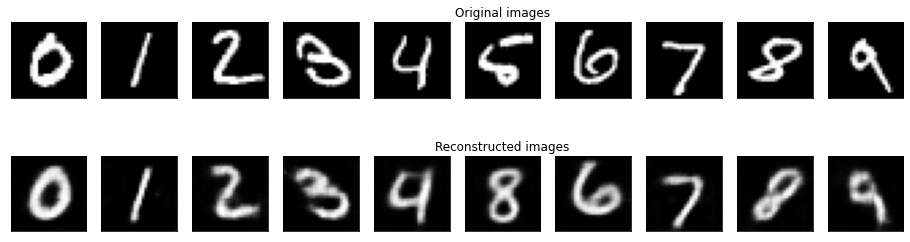

	 partial train loss (single batch): 0.025340
	 partial train loss (single batch): 0.026803
	 partial train loss (single batch): 0.026590
	 partial train loss (single batch): 0.027889
	 partial train loss (single batch): 0.026193
	 partial train loss (single batch): 0.027145
	 partial train loss (single batch): 0.026059
	 partial train loss (single batch): 0.025732
	 partial train loss (single batch): 0.026234
	 partial train loss (single batch): 0.027243
	 partial train loss (single batch): 0.026634
	 partial train loss (single batch): 0.027393
	 partial train loss (single batch): 0.027720
	 partial train loss (single batch): 0.025482
	 partial train loss (single batch): 0.026887
	 partial train loss (single batch): 0.025983
	 partial train loss (single batch): 0.026201
	 partial train loss (single batch): 0.025980
	 partial train loss (single batch): 0.026158
	 partial train loss (single batch): 0.025492
	 partial train loss (single batch): 0.028709
	 partial train loss (single batch

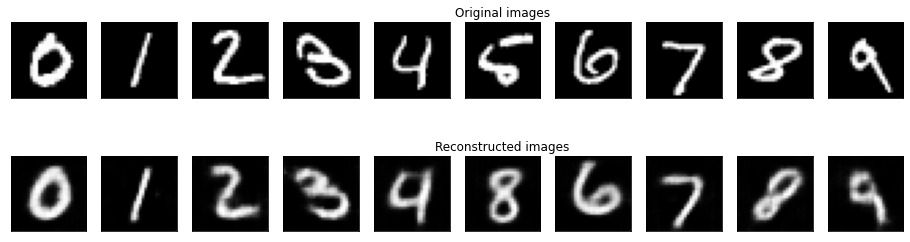

	 partial train loss (single batch): 0.025190
	 partial train loss (single batch): 0.026697
	 partial train loss (single batch): 0.026367
	 partial train loss (single batch): 0.027777
	 partial train loss (single batch): 0.026031
	 partial train loss (single batch): 0.026996
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.025608
	 partial train loss (single batch): 0.026020
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.026451
	 partial train loss (single batch): 0.027291
	 partial train loss (single batch): 0.027598
	 partial train loss (single batch): 0.025301
	 partial train loss (single batch): 0.026706
	 partial train loss (single batch): 0.025860
	 partial train loss (single batch): 0.026065
	 partial train loss (single batch): 0.025880
	 partial train loss (single batch): 0.026027
	 partial train loss (single batch): 0.025372
	 partial train loss (single batch): 0.028559
	 partial train loss (single batch

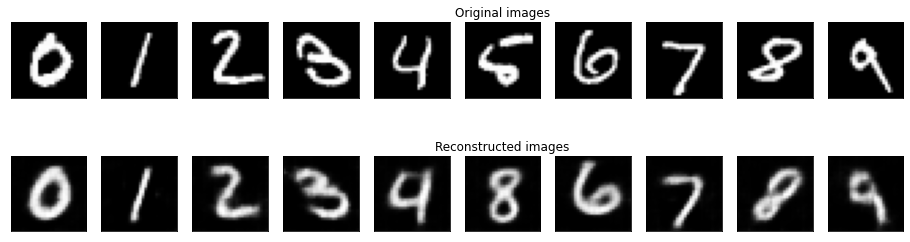

	 partial train loss (single batch): 0.025079
	 partial train loss (single batch): 0.026610
	 partial train loss (single batch): 0.026274
	 partial train loss (single batch): 0.027681
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.026851
	 partial train loss (single batch): 0.025843
	 partial train loss (single batch): 0.025479
	 partial train loss (single batch): 0.025948
	 partial train loss (single batch): 0.026998
	 partial train loss (single batch): 0.026364
	 partial train loss (single batch): 0.027223
	 partial train loss (single batch): 0.027449
	 partial train loss (single batch): 0.025234
	 partial train loss (single batch): 0.026485
	 partial train loss (single batch): 0.025831
	 partial train loss (single batch): 0.026081
	 partial train loss (single batch): 0.025786
	 partial train loss (single batch): 0.025916
	 partial train loss (single batch): 0.025280
	 partial train loss (single batch): 0.028417
	 partial train loss (single batch

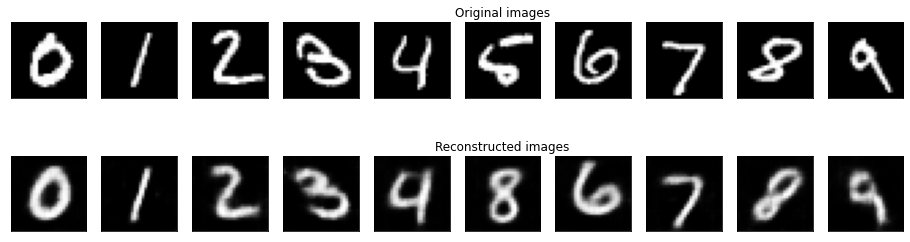

	 partial train loss (single batch): 0.024948
	 partial train loss (single batch): 0.026480
	 partial train loss (single batch): 0.026169
	 partial train loss (single batch): 0.027611
	 partial train loss (single batch): 0.025806
	 partial train loss (single batch): 0.026773
	 partial train loss (single batch): 0.025753
	 partial train loss (single batch): 0.025406
	 partial train loss (single batch): 0.025878
	 partial train loss (single batch): 0.026853
	 partial train loss (single batch): 0.026214
	 partial train loss (single batch): 0.027082
	 partial train loss (single batch): 0.027281
	 partial train loss (single batch): 0.025058
	 partial train loss (single batch): 0.026399
	 partial train loss (single batch): 0.025680
	 partial train loss (single batch): 0.025974
	 partial train loss (single batch): 0.025748
	 partial train loss (single batch): 0.025831
	 partial train loss (single batch): 0.025191
	 partial train loss (single batch): 0.028329
	 partial train loss (single batch

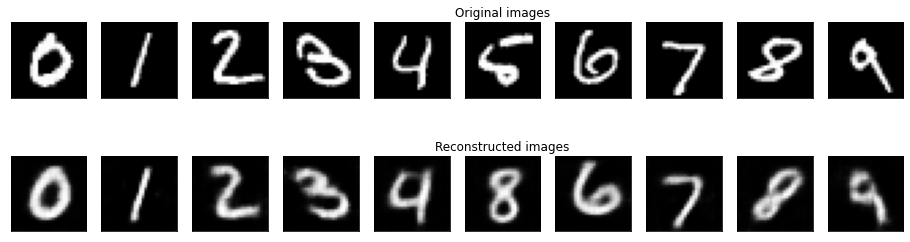

	 partial train loss (single batch): 0.024791
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.026021
	 partial train loss (single batch): 0.027430
	 partial train loss (single batch): 0.025776
	 partial train loss (single batch): 0.026721
	 partial train loss (single batch): 0.025674
	 partial train loss (single batch): 0.025452
	 partial train loss (single batch): 0.025829
	 partial train loss (single batch): 0.026762
	 partial train loss (single batch): 0.026111
	 partial train loss (single batch): 0.027010
	 partial train loss (single batch): 0.027181
	 partial train loss (single batch): 0.025020
	 partial train loss (single batch): 0.026293
	 partial train loss (single batch): 0.025686
	 partial train loss (single batch): 0.025936
	 partial train loss (single batch): 0.025656
	 partial train loss (single batch): 0.025807
	 partial train loss (single batch): 0.025153
	 partial train loss (single batch): 0.028219
	 partial train loss (single batch

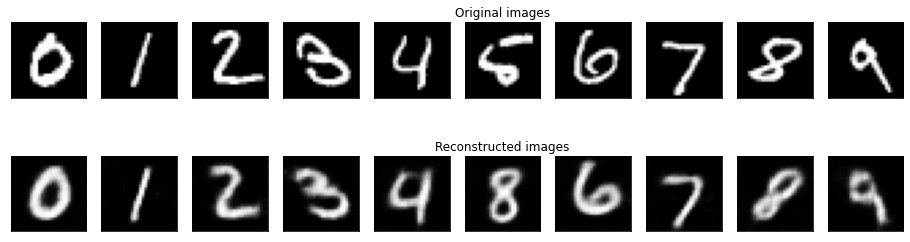

	 partial train loss (single batch): 0.024737
	 partial train loss (single batch): 0.026377
	 partial train loss (single batch): 0.025973
	 partial train loss (single batch): 0.027396
	 partial train loss (single batch): 0.025737
	 partial train loss (single batch): 0.026614
	 partial train loss (single batch): 0.025512
	 partial train loss (single batch): 0.025341
	 partial train loss (single batch): 0.025702
	 partial train loss (single batch): 0.026623
	 partial train loss (single batch): 0.026005
	 partial train loss (single batch): 0.026966
	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.024899
	 partial train loss (single batch): 0.026189
	 partial train loss (single batch): 0.025517
	 partial train loss (single batch): 0.025783
	 partial train loss (single batch): 0.025603
	 partial train loss (single batch): 0.025674
	 partial train loss (single batch): 0.025057
	 partial train loss (single batch): 0.028159
	 partial train loss (single batch

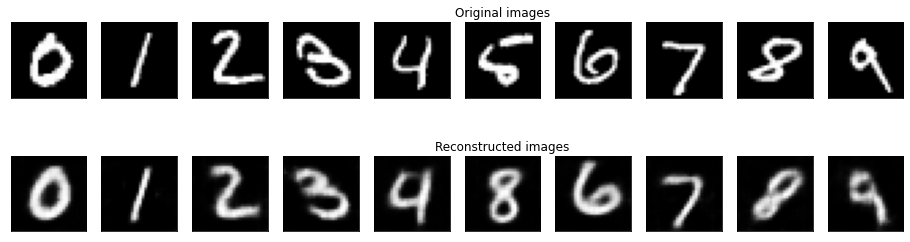

	 partial train loss (single batch): 0.024811
	 partial train loss (single batch): 0.026351
	 partial train loss (single batch): 0.026003
	 partial train loss (single batch): 0.027354
	 partial train loss (single batch): 0.025758
	 partial train loss (single batch): 0.026612
	 partial train loss (single batch): 0.025490
	 partial train loss (single batch): 0.025342
	 partial train loss (single batch): 0.025653
	 partial train loss (single batch): 0.026543
	 partial train loss (single batch): 0.025927
	 partial train loss (single batch): 0.026923
	 partial train loss (single batch): 0.027097
	 partial train loss (single batch): 0.024849
	 partial train loss (single batch): 0.026086
	 partial train loss (single batch): 0.025540
	 partial train loss (single batch): 0.025792
	 partial train loss (single batch): 0.025504
	 partial train loss (single batch): 0.025646
	 partial train loss (single batch): 0.025064
	 partial train loss (single batch): 0.028064
	 partial train loss (single batch

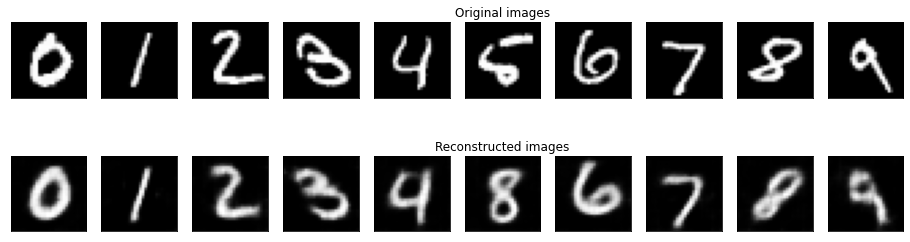

	 partial train loss (single batch): 0.024673
	 partial train loss (single batch): 0.026309
	 partial train loss (single batch): 0.025884
	 partial train loss (single batch): 0.027335
	 partial train loss (single batch): 0.025731
	 partial train loss (single batch): 0.026505
	 partial train loss (single batch): 0.025450
	 partial train loss (single batch): 0.025279
	 partial train loss (single batch): 0.025597
	 partial train loss (single batch): 0.026411
	 partial train loss (single batch): 0.025907
	 partial train loss (single batch): 0.026842
	 partial train loss (single batch): 0.026985
	 partial train loss (single batch): 0.024747
	 partial train loss (single batch): 0.025939
	 partial train loss (single batch): 0.025410
	 partial train loss (single batch): 0.025697
	 partial train loss (single batch): 0.025483
	 partial train loss (single batch): 0.025513
	 partial train loss (single batch): 0.025058
	 partial train loss (single batch): 0.028014
	 partial train loss (single batch

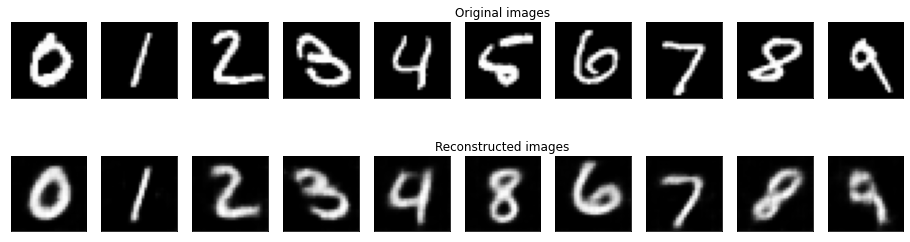

	 partial train loss (single batch): 0.024581
	 partial train loss (single batch): 0.026321
	 partial train loss (single batch): 0.025772
	 partial train loss (single batch): 0.027243
	 partial train loss (single batch): 0.025660
	 partial train loss (single batch): 0.026474
	 partial train loss (single batch): 0.025347
	 partial train loss (single batch): 0.025257
	 partial train loss (single batch): 0.025580
	 partial train loss (single batch): 0.026382
	 partial train loss (single batch): 0.025802
	 partial train loss (single batch): 0.026768
	 partial train loss (single batch): 0.026985
	 partial train loss (single batch): 0.024679
	 partial train loss (single batch): 0.025962
	 partial train loss (single batch): 0.025277
	 partial train loss (single batch): 0.025762
	 partial train loss (single batch): 0.025456
	 partial train loss (single batch): 0.025498
	 partial train loss (single batch): 0.025008
	 partial train loss (single batch): 0.027900
	 partial train loss (single batch

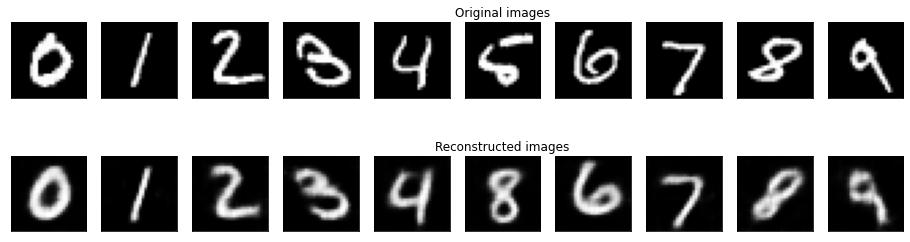

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)


## 

## Final evaluations

In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.026597799733281136

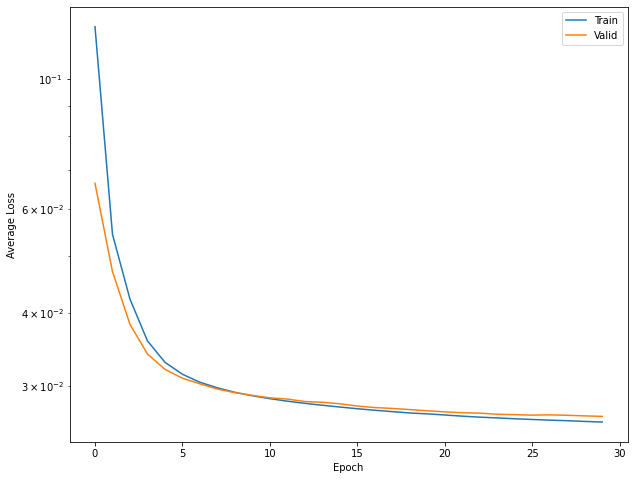

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()
